In [1]:
import numpy as np
import scipy as sc 
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
import pandas as pd
from IPython.display import display, Latex
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings

warnings.filterwarnings('ignore')
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')

In [2]:
import sys
sys.path.append(r"C:\Users\rrenard\Arkus_python\pricing_library\models\utilities")

from bin_calculator import bin_calculator  # type: ignore

# Data gathering & manipulation

In [3]:
# Importing the data from Yahoo Finance
def get_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

end_date = dt.datetime.now()
start_date = end_date - dt.timedelta(days=7300)

stock_1 = get_data('MSFT', start_date, end_date)

[*********************100%%**********************]  1 of 1 completed


In [4]:
# Order the data by date descending
stock_1 = stock_1.sort_values(by='Date', ascending=False)
stock_1

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-01-12,385.489990,388.679993,384.649994,388.470001,388.470001,21645700
2024-01-11,386.000000,390.679993,380.380005,384.630005,384.630005,27850800
2024-01-10,376.369995,384.170013,376.320007,382.769989,382.769989,25514200
2024-01-09,372.010010,375.989990,371.190002,375.790009,375.790009,20830000
2024-01-08,369.299988,375.200012,369.010010,374.690002,374.690002,23134000
...,...,...,...,...,...,...
2004-01-26,28.490000,28.830000,28.320000,28.799999,18.012865,58299600
2004-01-23,28.280001,28.760000,28.219999,28.480000,17.812717,127259100
2004-01-22,28.360001,28.440001,27.940001,28.010000,17.518759,78425200


In [5]:
# Calculating the log returns
stock_1['Log Returns'] = np.log(stock_1['Close']/stock_1['Close'].shift(1))
stock_1.dropna(inplace=True)

In [6]:
textstr1 = '\n'.join((
    r'$\mu=%.4f$' % (stock_1['Log Returns'].mean(), ),
    r'$\sigma=%.4f$' % (stock_1['Log Returns'].std(), )))

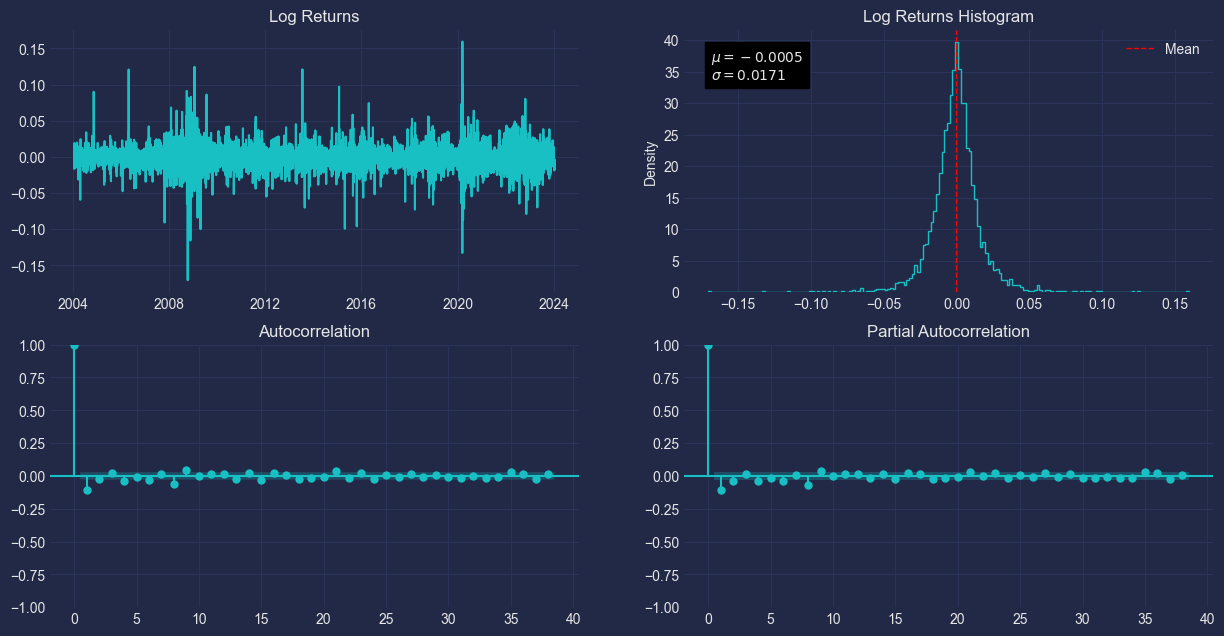

In [7]:
# Plotting the log returns, log returns histogram, ACF and PACF
fig, ax = plt.subplots(2,2, figsize=(15,7.5))
ax[0,0].plot(stock_1['Log Returns'])
ax[0,0].set_title('Log Returns')
ax[0,1].hist(stock_1['Log Returns'], bins=bin_calculator(stock_1['Log Returns']), density=True, histtype='step')
ax[0,1].axvline(stock_1['Log Returns'].mean(), linestyle= 'dashed', linewidth =1, color='red', label='Mean')
ax[0,1].text(0.05, 0.81, textstr1, transform=ax[0,1].transAxes, bbox=dict(facecolor='black', edgecolor='black'))
ax[0,1].legend()
ax[0,1].set_ylabel('Density')
ax[0,1].set_title('Log Returns Histogram')
plot_acf(stock_1['Log Returns'], ax=ax[1,0])
plot_pacf(stock_1['Log Returns'], ax=ax[1,1])
plt.show()

# Volatility clustering

“Large changes tend to be followed by large changes, of either sign, and small changes tend to be followed by small changes.” A quantitative manifestation of this fact is that, while returns themselves are uncorrelated, absolute returns $|r_t|$ or their squares display a positive, significant and slowly decaying autocorrelation function: $corr(|r_t| , |r_t + \tau|)$ for $\tau$ ranging from a few minutes to a several weeks. 

In [8]:
# Calculating the log returns squared and absolute log returns
stock_1['Log Returns Squared'] = stock_1['Log Returns']**2
stock_1['Absolute Log Returns'] = abs(stock_1['Log Returns'])

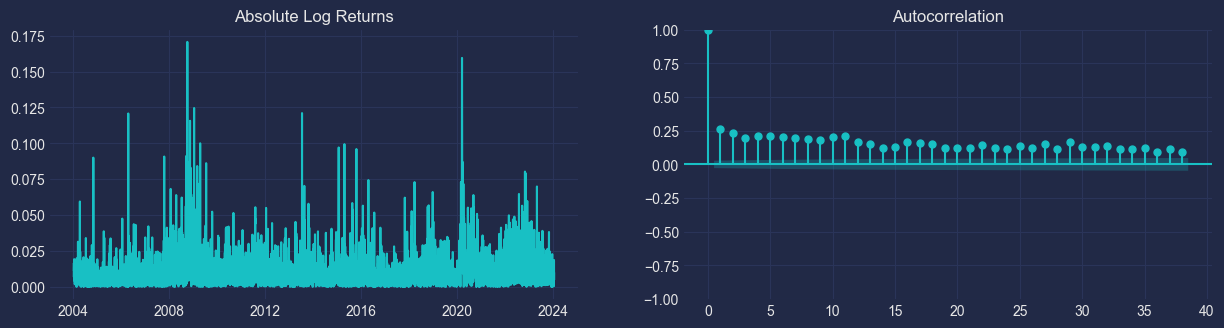

In [9]:
# Plotting the absolute log returns, and acf
fig, ax = plt.subplots(1,2, figsize=(15,3.5))
ax[0].plot(stock_1['Absolute Log Returns'])
ax[0].set_title('Absolute Log Returns')
plot_acf(stock_1['Absolute Log Returns'], ax=ax[1])
plt.show()

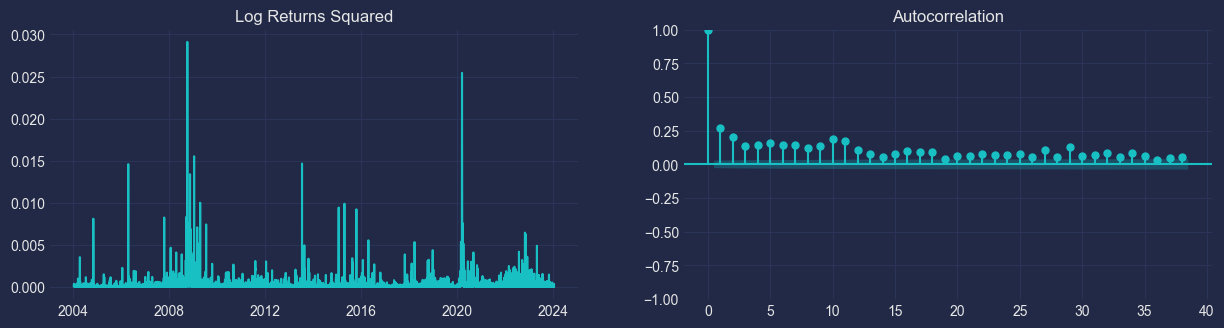

In [10]:
# Plotting the log returns squared, and acf
fig, ax = plt.subplots(1,2, figsize=(15,3.5))
ax[0].plot(stock_1['Log Returns Squared'])
ax[0].set_title('Log Returns Squared')
plot_acf(stock_1['Log Returns Squared'], ax=ax[1])
plt.show()

## Rolling volatility

In [11]:
# Calculating roling volatility
trading_days = 20
stock_1['1W_rolling_volatility_annualized'] = stock_1['Log Returns'].rolling(window=trading_days).std()*np.sqrt(252)

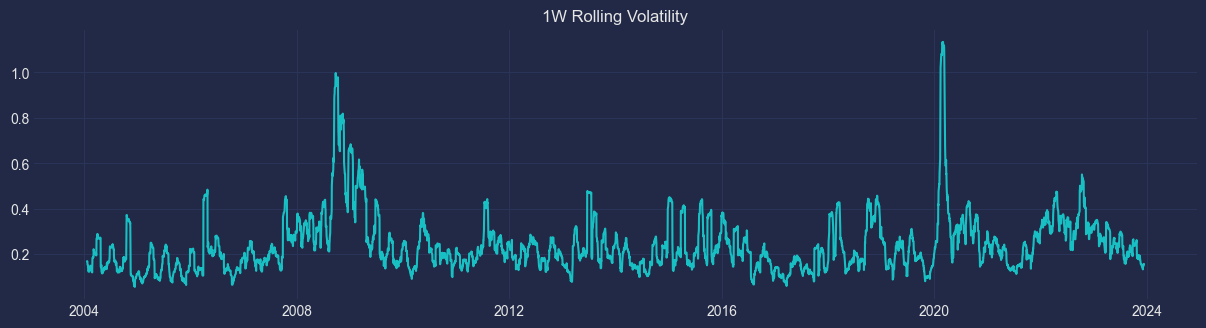

In [12]:
# Plotting the rolling volatility
fig, ax = plt.subplots(figsize=(15,3.5))
ax.plot(stock_1['1W_rolling_volatility_annualized'])
ax.set_title('1W Rolling Volatility')
plt.show()

# Ornstein-Uhlenbeck process

Ornstein-Uhlenbeck process is a stationary Gauss-Markov process of the form:

$dX_t = -kX_tdt + \sigma dW_t$

Sometimes, an extra drift term is added to form the well know Vasicek model:

$dX_t = k(\theta - X_t)dt + \sigma dW_t$

### Maximum Log-likelihood Estimation (MLE)

Probability Density Function of Normal Distribution is:

 $\Large f_\theta (x)=\frac{1}{\sqrt{2\pi \sigma^2}} e^{\frac{-(x-\mu)^2}{2 \sigma^2}}$


If we have random samples $y_i, i = 1,...,N$ from a density $f_\theta (y)$ indexed bu some parameter $\theta$.

Joint Probability Density Function or Likelihood function:
$ f(x_1,...x_n|\theta) =  f(x_1|\theta)...f(x_n|\theta) = \prod^n_{i=1}f(X_i|\theta) = L(\theta)$

The likelihood function is the density function regarded as a function of $\theta$.
$ L(\theta|x) = f(x|\theta), \theta \in \Theta$

The maximum likelihood estimator (MLE):

$\hat{\theta}(x) = arg \underset{\theta}{max} L(\theta|x)$

Log-probability of the observed sample is:

$l(\theta) = \sum^N_{i=1} log f_\theta (y_i)$

The principle of maximum likelihood assumes that the most reasonable values for $\theta$ are those for which the probability of the observed sample is
largest.

Essentially we are completing least squares for the additive error model $Y = f_\theta(X) + \epsilon$, with $\epsilon \sim N(0, \sigma^2)$, is equivalent to maximum likelihood using the conditional likelihood:

$f(Y|X, \theta) = N(log f_\theta (X), \sigma^2)$

If we take the likelihood function and derive the partial dericatives with respect the each respective parameter, make equal to zero, then we solve for MLE.

$L(\mu, \sigma^2 | \theta) = (\frac{1}{\sqrt{2\pi \sigma^2}} e^{\frac{-(x_1-\mu)^2}{2 \sigma^2}}) ... \frac{1}{\sqrt{2\pi \sigma^2}} e^{\frac{-(x_n-\mu)^2}{2 \sigma^2}} = \frac{1}{\sqrt{(2\pi \sigma^2)^n}} e^{-\frac{1}{2\sigma^2}\sum^n_{i=1}(x_i-\mu)^2}$

Log-likelihood function

$l(\mu, \sigma^2 | \theta) = ln L(\mu, \sigma^2 | \theta) = -\frac{n}{2}(ln2\pi+ln\sigma^2)-\frac{1}{2\sigma^2}\sum^n_{i=1}(x_i-\mu)^2$

Sometimes this is not differentiable but in the case of the normal distribution we can use Lagrange multiplier method to find maximisation parameters.

- $\frac{\delta}{\delta \mu}ln L(\mu, \sigma^2 | \theta) = 0 = \frac{1}{\sigma^2}\sum^n_{i=1}(x_i-\mu) = \frac{1}{\sigma^2}n(\overline{x} - \mu)$
- $\hat{\mu}(x) = \overline{x}$

This is a local maximum because the second partial derivative with respect to $\mu$ is negative, hence concave function.

- $\frac{\delta}{\delta \sigma^2}ln L(\mu, \sigma^2 | \theta) = 0 = -\frac{n}{2\sigma^2}+\frac{1}{2(\sigma^2)^2}\sum^n_{i=1}(x_i-\mu)^2 =  -\frac{n}{2(\sigma^2)^2}(\sigma^2+\frac{1}{n}\sum^n_{i=1}(x_i-\mu)^2)$
- $\hat{\sigma}^2(x)=\frac{1}{n}\sum^n_{i=1}(x_i-\overline{x})^2$

In [13]:
def mle_normal(x):
    mu_hat = x.mean() # biased estimator
    sigma2_hat = x.var() # biased estimator (variance of volatility)
    return mu_hat, sigma2_hat

In [14]:
mu = 0.5
sigma = 0.2 # volatility of volatility
N = 10000

np.random.seed(0)
x = np.random.normal(loc=mu, scale=sigma, size=(N,))

mu_hat, sigma2_hat = mle_normal(x)

for_mu_hat = r'$\hat{\mu} = '+format(round(mu_hat,3))+'$'
for_sigma2_hat = r'$\hat{\sigma} = '+format(round(np.sqrt(sigma2_hat),3))+'$' 

print('The MLE for data is:')
display(Latex(for_mu_hat))
display(Latex(for_sigma2_hat))

The MLE for data is:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

### Maximum Likelihood Estimator numerically

The maximum likelihood estimator (MLE):
$\hat{\theta}(x) = arg$ $\underset{\theta}{max}$ $L(\theta|x)$

$\hat{\theta}(x) = arg$ $\underset{\theta}{max}$  $ln$ $L(\theta|x)$

$L(\theta) = \prod^n_{i=1}f(X_i|\theta)$

$ln f(X∣\theta)=\sum_{i=1}^N ln f(x_i∣\theta)$

In [15]:
# Creating a function to calculate the log likelihood
def log_likelihood_normal(theta, x):
    mu= theta[0]
    sigma = theta[1]
    log_theta = np.sum(np.log(sc.stats.norm.pdf(x, loc=mu, scale=sigma)))
    return -log_theta

# Creating a function to define the bounds for the optimization
def sigma_pos(theta):
    sigma = theta[1]
    return sigma

In [16]:
constr = ({'type': 'ineq', 'fun': sigma_pos})
theta_0 = [1,1]
opt = sc.optimize.minimize(log_likelihood_normal, theta_0, args=(x,), constraints= constr)

for_mu_hat = r'$\hat{\mu} = '+format(round(opt.x[0],3))+'$'
for_sigma2_hat = r'$\hat{\sigma} = '+format(round(opt.x[1],3))+'$'

print('The MLE for data is:')
display(Latex(for_mu_hat))
display(Latex(for_sigma2_hat))

The MLE for data is:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

# Calibration of the Ornstein-Uhlenbeck process to market data

Use, Ito Calculus to find equation for $d(X_t)$ and then determine Expectation and Variance of $X_t$.

Find dynamics of $X_t$

1. Rearrange

- ${\displaystyle dX_{t}=\kappa (\theta -X_{t})\,dt+\sigma \,dW_{t}}$
- $dX_t= \kappa \theta dt -\kappa X_t dt+\sigma dW_t$
- $dX_t + \kappa X_t dt = \kappa \theta dt + \sigma dW_t$

We recognise: $d(e^{\kappa t} X_t) =  e^{\kappa t}dX_t + \kappa e^{\kappa t} X_t dt$,

2. so multiply equation through by $e^{\kappa t}$ term. Take integral over time horizon $t \in [0,T]$

- $\int^T_0 d(e^{\kappa t} X_t) = \int^T_0 \kappa \theta e^{\kappa t} dt + \int^T_0 \sigma e^{\kappa t} dW_t$
- $ e^{\kappa T} X_T - X_0 = \kappa \theta \frac{e^{\kappa T}-1}{\kappa} + \sigma \int^T_0 e^{\kappa t} dW_t$
- $ X_T = X_0 e^{-\kappa T} + \theta (1 - e^{-\kappa T}) + \sigma \int^T_0 e^{-\kappa (T-t)} dW_t$

Find $E[X_T]$

- $E[X_T] = E[X_0 e^{-\kappa T} + \theta (1 - e^{-\kappa T}) + \sigma \int^T_0 e^{-\kappa (T-t)} dW_t]$
- $E[X_T] = X_0 e^{-\kappa T} + \theta (1 - e^{-\kappa T})$

Find $Var[X_T] = E[(X_T- E[X_T])^2]$.  Substitute in $X_T$ and $E[X_T]$ derived above.
- $Var[X_T] = E[(\sigma \int^T_0 e^{-\kappa (T-t)} dW_t)^2]$

- Remember Ito Lemma, only term left after cross multiply $dWdW = dt$.
- $Var[X_T] = \sigma^2 \int^T_0 e^{-2\kappa (T-t)} dt$
- $Var[X_T] = \sigma^2 \frac{1-e^{-2\kappa T}}{2 \kappa}$
- $Var[X_T] = \frac{\sigma^2}{2 \kappa}(1-e^{-2\kappa T}) $

Now the stochastic process is normally distributed with $E[X_t]$ and $Var[X_t]$.
- $X_t \sim N(\mu, \sigma)$
- $X_t = \mu + \sigma  Z_t$ where $Z_t \sim N(0, 1)$

- $X_{t+\Delta t} = X_t e^{-\kappa T} + \theta (1 - e^{-\kappa T}) + \sigma \sqrt{\frac{(1-e^{-2\kappa T})}{2 \kappa}} N(0,1)$

### MLE of Ornstein-Uhlenbeck process
- $X_t \sim N(\mu, \overline{\sigma})$
- $E[X_{t+\delta t}] = X_t e^{-\kappa \delta t} + \theta (1 - e^{-\kappa \delta t})$
- $Var[X_{t+\delta t}] = \frac{\sigma^2}{2 \kappa}(1-e^{-2\kappa \delta t}) $

 $\Large f_{\overline{\theta}} (x_{t+\delta t} | x_t, \kappa, \theta, \sigma)=\frac{1}{\sqrt{2\pi \overline{\sigma}^2}} e^{\frac{-(x-\mu)^2}{2 \overline{\sigma}^2}}$
 - $\mu(x_t, \kappa, \theta) = x_t e^{-\kappa \delta t} + \theta (1 - e^{-\kappa \delta t})$
- $\overline{\sigma}(\kappa, \sigma) = \sigma \sqrt{\frac{(1-e^{-2\kappa \delta t})}{2 \kappa}}$

In [17]:
def mu(x, dt, kappa, theta):
    ekt = np.exp(-kappa*dt)
    return x*ekt + theta*(1-ekt)

def std(dt, kappa, sigma):
    e2kt = np.exp(-2*kappa*dt)
    return sigma*np.sqrt((1-e2kt)/(2*kappa))

In [18]:
def log_likelihood_OU(theta_hat, x):
    kappa = theta_hat[0]
    theta = theta_hat[1]
    sigma = theta_hat[2]

    x_dt = x[1:]
    x_t = x[:-1]

    dt = 1/252

    mu_OU = mu(x_t, dt, kappa, theta)
    sigma_OU = std(dt, kappa, sigma)

    l_theta_hat = np.sum(np.log(sc.stats.norm.pdf(x_dt, loc=mu_OU, scale=sigma_OU)))

    return -l_theta_hat

def kappa_pos(theta_hat):
    kappa = theta_hat[0]
    return kappa

def sigma_pos(theta_hat):
    sigma = theta_hat[2]
    return sigma

In [19]:
volatility = stock_1['1W_rolling_volatility_annualized'].values
volatility = volatility[~np.isnan(volatility)]
volatility

array([0.15668066, 0.15382647, 0.15532558, ..., 0.16847   , 0.16855599,
       0.16946059])

In [20]:
cons_set = [{'type':'ineq', 'fun': kappa_pos},
            {'type':'ineq', 'fun': sigma_pos}]

theta0 = [1,1,1]
opt = sc.optimize.minimize(fun=log_likelihood_OU, x0=theta0, args=(volatility,), constraints=cons_set)

opt

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -12019.346125373435
       x: [ 3.648e+00  2.408e-01  3.513e-01]
     nit: 27
     jac: [ 0.000e+00 -2.319e-03 -2.734e-02]
    nfev: 116
    njev: 25

In [21]:
kappa = round(opt.x[0],3)
theta = round(opt.x[1],3)
sigma = round(opt.x[2],3)
vol0 = volatility[-1]

for_kappa_hat = r'$\hat{\kappa} = '+str(kappa)+'$'
for_theta_hat = r'$\hat{\theta} = '+str(theta)+'$'
for_sigma_hat = r'$\hat{\sigma} = '+str(sigma)+'$'

print('The MLE for data is:')
display(Latex(for_kappa_hat))
display(Latex(for_theta_hat))
display(Latex(for_sigma_hat))
print('Last Volatility', round(vol0,3))

The MLE for data is:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Last Volatility 0.169


# Simulating an Ornstein-Uhlenbeck process

${\displaystyle dX_{t}=\kappa (\theta -X_{t})\,dt+\sigma \,dW_{t}}$

### Continuous time simulation

$ X_t = X_0 e^{-\kappa t} + \theta (1 - e^{-\kappa t}) + \sigma \int^t_0 e^{-\kappa (t-s)} dW_s$

In [33]:
# define parameters
Time = 63/252 # in year
M = 10000

Z = np.random.normal(loc=0, scale=1, size=(M))

def mu(x, dt, kappa, theta):
    ekt = np.exp(-kappa*dt)
    return x*ekt + theta*(1-ekt)

def std(dt, kappa, sigma):
    e2kt = np.exp(-2*kappa*dt)
    return sigma*np.sqrt((1-e2kt)/(2*kappa))

drift_OU = mu(vol0, Time, kappa, theta)
diffusion_OU = std(Time, kappa, sigma)
vol_OU = drift_OU + diffusion_OU * Z

textstr2 = '\n'.join((
    r'$\mu=%.4f$' % (vol_OU.mean(), ),
    r'$\sigma=%.4f$' % (vol_OU.std(), )))



In [35]:
Z

array([-1.58194581,  0.85333013,  0.49413673, ...,  1.0634652 ,
       -0.28440481, -0.14412492])

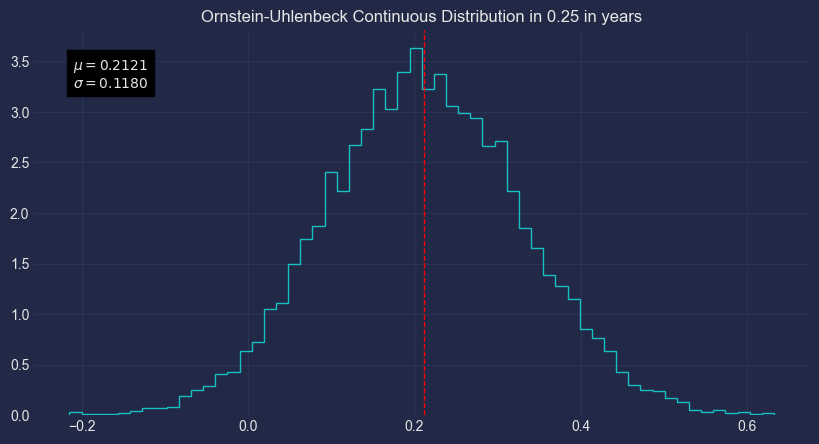

In [34]:
fig, ax = plt.subplots(figsize=(10,5))
ax.hist(vol_OU, bins=bin_calculator(vol_OU), density=True, histtype='step')
ax.axvline(vol_OU.mean(), color='red', linestyle = 'dashed', label='Mean', linewidth=1)
ax.text(0.05, 0.85, textstr2, transform=ax.transAxes ,bbox=dict(facecolor='black', edgecolor='black'))
ax.set_title(f'Ornstein-Uhlenbeck Continuous Distribution in {Time} in years')
ax.set_label('Volatility')
plt.show()

### Discretized SDE simulation using python loop

Euler-Maryuama discretisation: This is an approximation of variance...

$\Delta x_{t+1} = \kappa(\theta - x_t) \Delta t + \sigma \sqrt{\Delta t} \epsilon_t$

where parameters are assigned as from above optimisation

In [24]:
# Initialise Parameters for discretization
years = 1 # horizon in years

dt = 1/252 # time step

M = 10 # number of simulations
N = int(years/dt) # number of time steps

vol0 = volatility[-1] # initial volatility

In [25]:
def OU_simulate(kappa, theta, sigma, number_of_paths, horizon):
    days = 1
    years = horizon
    dt = days/252
    M = number_of_paths
    N = int(years/dt)
    vol_OU = np.full(shape=(N, M), fill_value=vol0)
    Z = np.random.normal(size=(N, M))
    
    for i in range(1,N):
        drift_OU = kappa*(theta - vol_OU[i-1])*dt
        diffusion_OU = sigma*np.sqrt(dt)
        vol_OU[i] = vol_OU[i-1] + drift_OU + diffusion_OU*Z[i] # Maybe take the absolute value of the volatility here to avoid negative values as volatility is always positive?
        
    vol_OU = np.concatenate((np.full(shape=(1, M), fill_value=vol0), vol_OU ))
    
    return vol_OU    

In [26]:
Z.shape

(10000,)

In [27]:
ou_sim = OU_simulate(kappa, theta, sigma, 10000, 1)

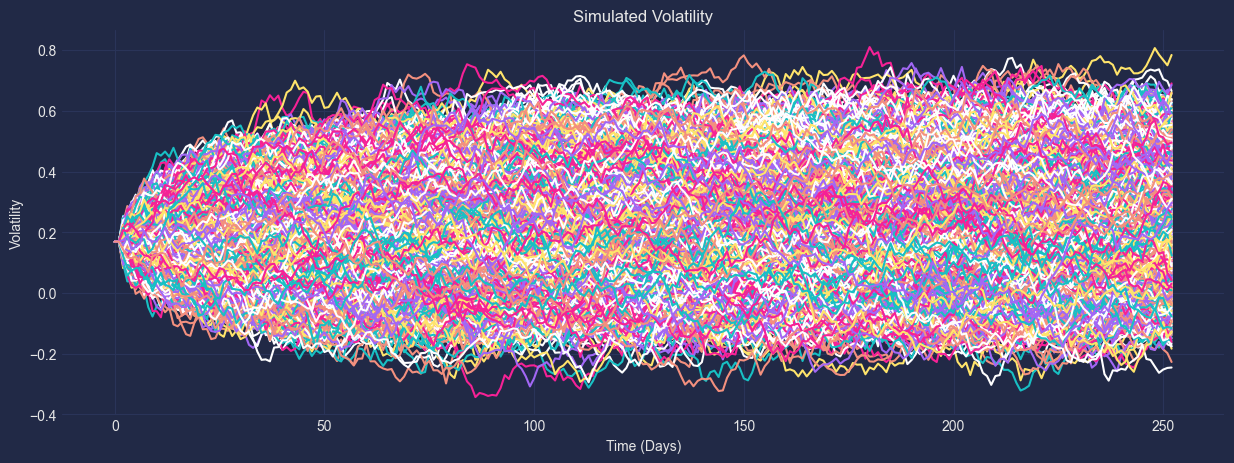

In [28]:
# Plotting the simulated volatility
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(ou_sim)
ax.set_title('Simulated Volatility')
ax.set_ylabel('Volatility')
ax.set_xlabel('Time (Days)')
plt.show()

In [29]:
# calculate the mean of the simulated volatility at each time step
ou_sim_mean = np.mean(ou_sim, axis=1)
ou_sim_mean

array([0.16946059, 0.16946059, 0.17045185, 0.17138787, 0.17251135,
       0.17321479, 0.1743975 , 0.17568305, 0.17704607, 0.17828109,
       0.1793233 , 0.18034441, 0.18164774, 0.18269654, 0.18378455,
       0.18468014, 0.18549386, 0.18621716, 0.18672021, 0.18741016,
       0.18829057, 0.18884145, 0.18946095, 0.18992086, 0.19061655,
       0.19141701, 0.19230092, 0.19300359, 0.19365197, 0.19437594,
       0.19517081, 0.19569279, 0.19635048, 0.197379  , 0.1980635 ,
       0.19885093, 0.19993316, 0.20063924, 0.20118111, 0.20213482,
       0.20274725, 0.20305667, 0.20368694, 0.20466456, 0.20526708,
       0.2060502 , 0.20608531, 0.20666972, 0.20727043, 0.20777781,
       0.2083266 , 0.20912312, 0.20980358, 0.20977143, 0.21045021,
       0.21128977, 0.21166013, 0.211964  , 0.2124684 , 0.21305808,
       0.21364865, 0.21386922, 0.21410822, 0.21448939, 0.21473745,
       0.2150703 , 0.21526752, 0.21574572, 0.21630748, 0.21701489,
       0.21752617, 0.21762951, 0.21788623, 0.21799219, 0.21818

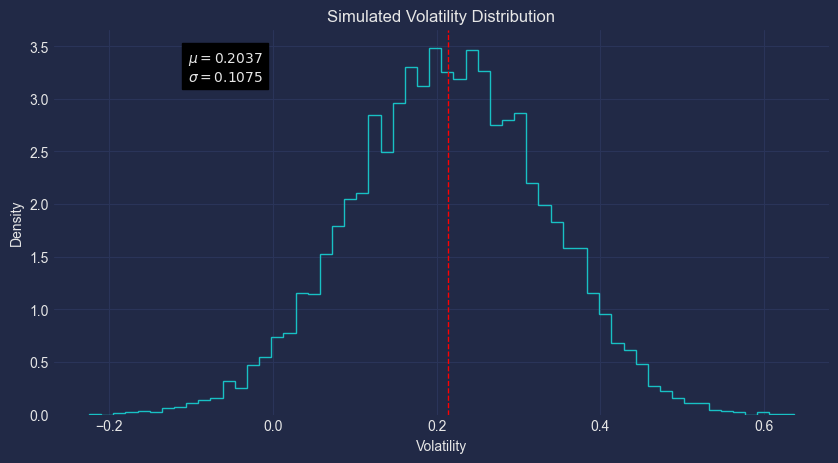

In [30]:
textstr3 = '\n'.join((
    r'$\mu=%.4f$' % (ou_sim[42].mean(), ),
    r'$\sigma=%.4f$' % (ou_sim[42].std(), )))

fig, ax_ou_sim = plt.subplots(figsize=(10,5))
ax_ou_sim.hist(ou_sim[62], bins=bin_calculator(ou_sim[62]), density=True, histtype='step')
ax_ou_sim.axvline(ou_sim[62].mean(), color='red', linestyle = 'dashed', label='Mean', linewidth=1)
ax_ou_sim.text(0, 0.85, textstr3, transform=ax.transAxes ,bbox=dict(facecolor='black', edgecolor='black'))
ax_ou_sim.set_title('Simulated Volatility Distribution')
ax_ou_sim.set_xlabel('Volatility')
ax_ou_sim.set_ylabel('Density')
plt.show()